In [23]:
import os
import pandas as pd
import PyPDF2
import re
import requests

##########################################################
from dotenv import load_dotenv

import os

load_dotenv()
ASU_key = os.environ.get("ASU_key")  

In [29]:
df = pd.read_csv('C:\programming_projects\RAG_fine_tune\web_crawl\cleaned_ASU_webpage_04_07_2025.csv')
df.rename(columns={'word_count': 'orig_word_count', 'char_count': 'orig_char_count'}, inplace = True)
df.head()

<>:1: SyntaxWarning: invalid escape sequence '\p'
<>:1: SyntaxWarning: invalid escape sequence '\p'
C:\Users\onyxs\AppData\Local\Temp\ipykernel_39296\967690966.py:1: SyntaxWarning: invalid escape sequence '\p'
  df = pd.read_csv('C:\programming_projects\RAG_fine_tune\web_crawl\cleaned_ASU_webpage_04_07_2025.csv')
C:\Users\onyxs\AppData\Local\Temp\ipykernel_39296\967690966.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('C:\programming_projects\RAG_fine_tune\web_crawl\cleaned_ASU_webpage_04_07_2025.csv')


,url,depth,title,topic,orig_word_count,orig_char_count,page_text,filename,cleaned_text,langauage
0,https://admission.asu.edu/undergrad/nondegree,1.0,Nondegree student Admission ASU,Admissions Application Process,93,548,Nondegree requirementsTo be eligible to take c...,webpage_analysis_run_10.csv,Nondegree requirementsTo be eligible to take c...,en
1,https://asuonline.asu.edu/admission/first-year/,1.0,First Year Students ASU Online,ASU s Global Online Education,55,325,ASU Online empowers first-year students to tak...,webpage_analysis_run_10.csv,ASU Online empowers first year students to tak...,en
2,https://bios.asu.edu/team-members/rebecca-garley/,6.0,Rebecca Garley BIOS,NaN,121,670,Becky received her BSc in Ocean and Earth Scie...,webpage_analysis_run_100.csv,Becky received her BSc in Ocean and Earth Scie...,en
3,https://bios.asu.edu/about-bios/team-members/b...,6.0,Dr. Brett Jameson BIOS,NaN,348,2351,Brett is a Postdoctoral Scientist in the Coral...,webpage_analysis_run_100.csv,Brett is a Postdoctoral Scientist in the Coral...,en
4,https://bios.asu.edu/about/team-members/rachel...,6.0,Rachel Parsons BIOS,NaN,624,4087,Rachel is a microbial oceanographer who invest...,webpage_analysis_run_100.csv,Rachel is a microbial oceanographer who invest...,en


<Axes: >

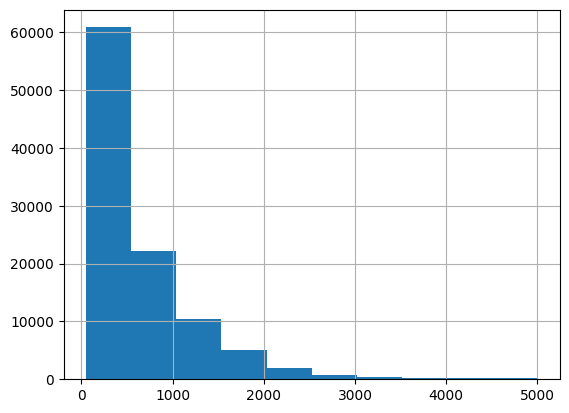

In [31]:
df['orig_word_count'][df['orig_word_count'] < 5000].hist()

In [32]:
df_temp = df[(df['orig_word_count'] > 5000) & (df['orig_word_count'] < 6000)]
df_temp.shape

(403, 10)

In [ ]:
import pandas as pd

def chunk_text_with_overlap(df, text_column, chunk_size=500, overlap=20):
    """
    Breaks a column of text in a pandas DataFrame into chunks of a specified size
    with a given overlap. Keeps all other columns and their original values.

    Args:
        df (pd.DataFrame): The input DataFrame.
        text_column (str): The name of the column containing the text to chunk.
        chunk_size (int): The desired size of each text chunk in words.
        overlap (int): The number of overlapping words between consecutive chunks.

    Returns:
        pd.DataFrame: A new DataFrame where each row represents a chunk of the
                      original text, along with the values from the other columns
                      and the original full text.
    """
    new_rows = []
    for index, row in df.iterrows():
        text = row[text_column]
        words = text.split()
        n_words = len(words)
        start = 0
        while start < n_words:
            end = min(start + chunk_size, n_words)
            chunk = " ".join(words[start:end])
            new_row = row.to_dict()
            new_row['chunked_text'] = chunk
            new_row['original_text'] = text  # Keep the original full text
            new_rows.append(new_row)
            start += (chunk_size - overlap)
            if start < overlap:  # Ensure we don't go negative
                start = 0

    new_df = pd.DataFrame(new_rows)
    return new_df

chunked_df = chunk_text_with_overlap(df.copy(), 'cleaned_text')

df['chunked_word_count'] = df['chunked_text'].apply(lambda x: len(str(x).split()))
df['chunked_char_count'] = df['chunked_text'].str.len()

# print(chunked_df.head())
print(f"\nShape of the original DataFrame: {df.shape}")
print(f"Shape of the chunked DataFrame: {chunked_df.shape}")


Shape of the original DataFrame: (103419, 10)
Shape of the chunked DataFrame: (220527, 12)


In [34]:
chunked_df.head()

,url,depth,title,topic,orig_word_count,orig_char_count,page_text,filename,cleaned_text,langauage,chunked_text,original_text
0,https://admission.asu.edu/undergrad/nondegree,1.0,Nondegree student Admission ASU,Admissions Application Process,93,548,Nondegree requirementsTo be eligible to take c...,webpage_analysis_run_10.csv,Nondegree requirementsTo be eligible to take c...,en,Nondegree requirementsTo be eligible to take c...,Nondegree requirementsTo be eligible to take c...
1,https://asuonline.asu.edu/admission/first-year/,1.0,First Year Students ASU Online,ASU s Global Online Education,55,325,ASU Online empowers first-year students to tak...,webpage_analysis_run_10.csv,ASU Online empowers first year students to tak...,en,ASU Online empowers first year students to tak...,ASU Online empowers first year students to tak...
2,https://bios.asu.edu/team-members/rebecca-garley/,6.0,Rebecca Garley BIOS,NaN,121,670,Becky received her BSc in Ocean and Earth Scie...,webpage_analysis_run_100.csv,Becky received her BSc in Ocean and Earth Scie...,en,Becky received her BSc in Ocean and Earth Scie...,Becky received her BSc in Ocean and Earth Scie...
3,https://bios.asu.edu/about-bios/team-members/b...,6.0,Dr. Brett Jameson BIOS,NaN,348,2351,Brett is a Postdoctoral Scientist in the Coral...,webpage_analysis_run_100.csv,Brett is a Postdoctoral Scientist in the Coral...,en,Brett is a Postdoctoral Scientist in the Coral...,Brett is a Postdoctoral Scientist in the Coral...
4,https://bios.asu.edu/about/team-members/rachel...,6.0,Rachel Parsons BIOS,NaN,624,4087,Rachel is a microbial oceanographer who invest...,webpage_analysis_run_100.csv,Rachel is a microbial oceanographer who invest...,en,Rachel is a microbial oceanographer who invest...,Rachel is a microbial oceanographer who invest...


In [ ]:

##########################################################

### files
for ii in range(0, len(files)):
    title = re.sub(r'.pdf', ' ', files[ii])

    print(ii, files[ii])
    

    # Open the PDF in read-binary mode
    with open(folder_path+files[ii], "rb") as pdf_file:
        # Create a PDF reader object
        pdf_reader = PyPDF2.PdfReader(pdf_file)

        # Get the number of pages
        total_page = len(pdf_reader.pages)

    ### pages
    for iii in range(0, total_page):
        page_no = iii
        print('page number' , iii)

        # Open the PDF in read-binary mode
        with open(folder_path+files[ii], "rb") as pdf_file:
            # Create a PDF reader object
            pdf_reader = PyPDF2.PdfReader(pdf_file)

            # Extract text from the first page
            page = pdf_reader.pages[page_no]
            text = page.extract_text()

        cleaned_string = clean_string(text)
        
        word_count = len(cleaned_string.split())

        if word_count > 1000:
            try:
                chunks = parse_string_with_overlap(cleaned_string, int(word_count/4), 15)
            except ValueError as e:
                chunks = cleaned_string
                print(f"Error: {e}")
        if word_count <= 1000:
            try:
                chunks = parse_string_with_overlap(cleaned_string, word_count, 0)
            except:
                print("word_count:", word_count,"\ncleaned_string:", cleaned_string, "\n\n")

        ### some pages dont have any text and we dont care about that!
        if word_count > 5:
            ##########################################
            ## section type
            api_url = 'https://api-dev-poc.aiml.asu.edu/queryV2'
            bearer_token = ASU_key
            json_payload = {
                "query": "what part of a document is the following text from in a academic paper {cleaned_string}? only respond with the section type, no other text.".format(cleaned_string=cleaned_string),
                "model_provider": "gcp-deepmind",
                "model_name": "geminiflash1_5",
            }
            headers = {
                "Authorization": f"Bearer {bearer_token}",
                "Content-Type": "application/json"
            }
            try:
                response = requests.post(api_url, headers=headers, json=json_payload)
                response.raise_for_status()
                result_document_section = response.json().get("response")
                # print("result:", result_document_section)
            except requests.exceptions.RequestException as e:
                print(f"API request error: {e}")
            except Exception as e:
                print(f"Unexpected error: {e}")
            
            for i, chunk in enumerate(chunks):
                ##########################################
                ## questions

                query = """given that the following text from the document {title} on page {page_no} of total page {total_page}, here is the text:\n {chunk}\n\n 
                            what are some good questions to ask about the {section} section? Please respond with question and answers for 3 questions.

                            the questions need to be well defined. Try to use the text as much as possible when crafting the answer. Answers need to be at least 2 sentences long.

                            Please use the following format for the response:

                            **Question 1:**
                            **Answer 1:**

                            **Question 2:**
                            **Answer 2:**

                            **Question 3:**
                            **Answer 3:**
                            """.format(
                                page_no = page_no,
                                total_page = total_page,
                                chunk=chunk,
                                section=result_document_section,
                                title=title)

                json_payload = {
                    "query": query,
                    "model_provider": "gcp-deepmind",
                    "model_name": "geminiflash1_5",
                }
                headers = {
                    "Authorization": f"Bearer {bearer_token}",
                    "Content-Type": "application/json"
                }
                try:
                    response = requests.post(api_url, headers=headers, json=json_payload)
                    response.raise_for_status()
                    result = response.json().get("response")
                    # print("result:", result)
                except requests.exceptions.RequestException as e:
                    print(f"API request error: {e}")
                except Exception as e:
                    print(f"Unexpected error: {e}")
                
                ###################################################
                ## save out
                parts = result.split("**")  # Split the string at **
                parts_no = [[2, 4], [6, 8], [10, 12]]


                for i in range(0, 3):
                    try:
                        pt1 = parts_no[i][0]
                        pt2 = parts_no[i][1]

                        Q1 = pd.DataFrame(data={'section':[result_document_section],
                                                'title':[title],
                                                'file_name':[files[ii]],
                                                'document_type':['academic paper'],
                                                'subject':['science, chemistry, materials science'],
                                                'page': [page_no],
                                                'pg_word_ct':[word_count],
                                                'total_pages': [total_page],
                                                'contex': [chunks],
                                                'page_whole': [cleaned_string],
                                                'question':[parts[pt1]],
                                                'answer':[parts[pt2]]
                                                })
                        df_out = pd.concat([Q1, df_out], ignore_index=True)
                        df_out.to_csv('silver_data.csv', index=False)

                    except Exception as e:
                        print(f"Unexpected error: {e}")
                        # print("result:", result)
